# Corona - Map visualization (Germany)

A notebook to explore how to visualiza data on a map.

In [128]:
#presentation helper to toggle code cells visibility
from IPython.display import HTML

HTML('''
<style>
div.output_stderr {
display: none !important;
}
</style>

<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()""><input type="submit" value="Click here to toggle on/off the raw code.""></form>''')

## Setup

- install folium, geopandas and geopy
- define options to fetch new data or proceed on cache
- load intial data

In [129]:
#install required dependencies
!pip install folium --quiet 
!pip install dppd --quiet 
!pip install geopandas --quiet 
!pip install geopy --quiet 

In [130]:
#imports

# pandas
import pandas as pd

# dplyr-style for python
from dppd import dppd
dp, X = dppd()

#geospatial support
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

#for dates
from datetime import date

In [131]:
#Options
isTestEnabled = False #execute also tests with test code
isCacheEnabled = True #fetch new data or use cached data
isGeocoderEnabled = False #use geocoder to extend the dataset with location data or cache

In [132]:

if(not isCacheEnabled):
    # Read DE data from RKI's repository & save as cache
    df_rki_de = pd.read_csv('https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv')
    df_rki_de.to_csv("./cache/df_rki_de.csv")
else:
    # Read DE data from local cache
    df_rki_de = pd.read_csv("./cache/df_rki_de.csv")

In [133]:
df_rki_de.head()

,Unnamed: 0,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,0,4529737,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"02.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
1,1,4529738,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"02.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
2,2,4529739,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"02.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
3,3,4529740,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"02.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
4,4,4529741,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"02.05.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt


## Data preperation

- aggregate by region
- summarize infections, recoveries and deaths

In [134]:
df_prepared = (dp(df_rki_de)
 .select(['Meldedatum','Bundesland','Landkreis','Altersgruppe',
         'AnzahlFall','AnzahlTodesfall','AnzahlGenesen'])
#.groupby(['Meldedatum','Altersgruppe'])
 .groupby(['Bundesland'])
 .sum()
#filter by time               
# .loc['2020-04-10':'2020-04-17']
 .reset_index()
 .pd)

In [135]:
df_prepared.head(20)

,Bundesland,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
0,Baden-Württemberg,32132,1402,24498
1,Bayern,42642,1885,33660
2,Berlin,5941,152,4996
3,Brandenburg,2886,122,2249
4,Bremen,871,30,541
5,Hamburg,4608,163,3675
6,Hessen,8485,364,6607
7,Mecklenburg-Vorpommern,694,18,630
8,Niedersachsen,10245,451,8275
9,Nordrhein-Westfalen,33204,1268,27505


## Simple & quick plots by pandas

To get an idea, what's in the data

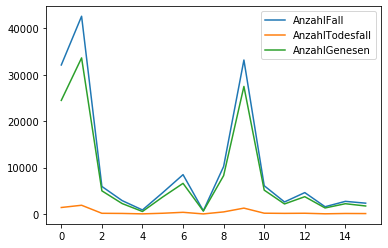

In [136]:
df_prepared.plot()

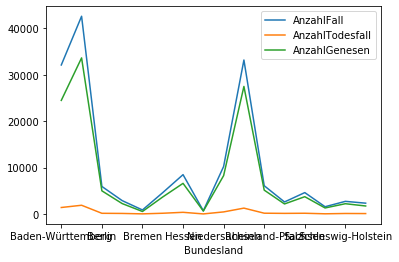

In [137]:
df_prepared.plot(x='Bundesland')

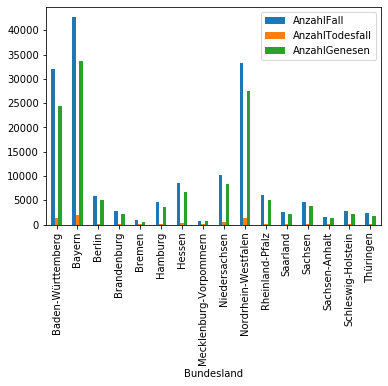

In [138]:
df_prepared.plot.bar(x='Bundesland')

## Extend dataset with missing location data

lat long geocoding using nominatim

In [139]:
#test
if(isTestEnabled):
    locator = Nominatim(user_agent="Geocoder")
    location = locator.geocode("Berlin")
    print(location)
    print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

    

In [140]:
if(isGeocoderEnabled):
    #geocode dataset
    locator = Nominatim(user_agent="Geocoder")
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
    df_prepared['location'] = df_prepared['Bundesland'].apply(geocode)
    df_prepared['point'] = df_prepared['location'].apply(lambda loc: tuple(loc.point) if loc else None)
    #split point column into latitude, longitude and altitude columns
    df_prepared[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_prepared['point'].tolist(), index=df_prepared.index)
    #cache geocoded dataset
    df_prepared.to_csv("./cache/df_rki_de_summary_geocoded.csv")
else:
    #use points from cached geocoded dataset
    df_locations = pd.read_csv('./cache/df_rki_de_summary_geocoded.csv')
    df_locations = (dp(df_locations)
     .select(['Bundesland','latitude','longitude','altitude'])
     .reset_index()
     .pd)
    #df_merged = pd.merge(df_prepared, df_locations, how='right', on=['Bundesland'])
    df_prepared = df_prepared.merge(df_locations, on='Bundesland');

In [141]:
df_prepared.head(20)

,Bundesland,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,index,latitude,longitude,altitude
0,Baden-Württemberg,32132,1402,24498,0,48.629697,9.194953,0.0
1,Bayern,42642,1885,33660,1,48.946756,11.403872,0.0
2,Berlin,5941,152,4996,2,52.517036,13.388860,0.0
3,Brandenburg,2886,122,2249,3,52.845549,13.246130,0.0
4,Bremen,871,30,541,4,53.075820,8.807165,0.0
5,Hamburg,4608,163,3675,5,53.543764,10.009913,0.0
6,Hessen,8485,364,6607,6,50.611854,9.190973,0.0
7,Mecklenburg-Vorpommern,694,18,630,7,53.773523,12.575575,0.0
8,Niedersachsen,10245,451,8275,8,52.839853,9.075962,0.0
9,Nordrhein-Westfalen,33204,1268,27505,9,51.478180,7.554234,0.0


# Folium Map

In [142]:
import folium

In [143]:
#map germany
location = locator.geocode("Fulda")

map1 = folium.Map(
    location=[location.latitude,location.longitude],
    #tiles='cartodbpositron',
    tiles='CartoDB dark_matter',
    #tiles='Stamen Toner',
    zoom_start=5.5
)

#map1

In [144]:
#df_prepared.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
#map1

In [145]:
#customized map germany

from folium.plugins import MarkerCluster

location = locator.geocode("Fulda")

map_de = folium.Map(
    location=[location.latitude,location.longitude],
    tiles='Stamen Toner',
    #tiles='CartoDB dark_matter',
    #tiles='Stamen Watercolor',
    #tiles='Stamen Terrain',
    
    zoom_start=5.5
)

map_de

mc = MarkerCluster(name="Corona marker cluster infected", disableClusteringAtZoom=5)
mc2 = MarkerCluster(name="Corona marker cluster recovered", disableClusteringAtZoom=5)
mc3 = MarkerCluster(name="Corona marker cluster dead", disableClusteringAtZoom=5)

for index, row in df_prepared.dropna().iterrows():
    popup_text = "{}<br><br> infected: {}<br> recovered: {}<br> dead: {}".format(
                      row["Bundesland"],
                      row["AnzahlFall"],
                      row["AnzahlGenesen"],
                      row["AnzahlTodesfall"]
                      )
    #circle radius in meter, circle has 2*r like in 2m distance per person/fall
    folium.Circle(location=[row["latitude"],row["longitude"]],
                        radius= row["AnzahlFall"],
                        color="orange",
                        popup=popup_text,
                        fill=True).add_to(mc)
    folium.Circle(location=[row["latitude"],row["longitude"]],
                        radius= row["AnzahlGenesen"],
                        color="green",
                        popup=popup_text,
                        fill=True).add_to(mc2)
    folium.Circle(location=[row["latitude"],row["longitude"]],
                        radius= row["AnzahlTodesfall"],
                        color="red",
                        popup=popup_text,
                        fill=True).add_to(mc3)
   
mc.add_to(map_de)
mc2.add_to(map_de)
mc3.add_to(map_de)
map_de


## Save the result map as html

In [146]:
today = date.today()
path='./cache/' + today.strftime("%Y_%m_%d") + '_corona_map_de.html'
map_de.save(path)

# Improve resolution to 'Landkreis' data

- prepare a new dataset
- aggregate by landkreis
- geocode Landkreis column
- display multiple markercluster

In [147]:
df_landkreis = (dp(df_rki_de)
 .select(['Meldedatum','Bundesland','Landkreis','Altersgruppe',
         'AnzahlFall','AnzahlTodesfall','AnzahlGenesen'])
 .groupby(['Landkreis'])
 .sum()
#filter by time               
# .loc['2020-04-10':'2020-04-17']
 .reset_index()
 .pd)

In [148]:
df_landkreis.head()

,Landkreis,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
0,LK Ahrweiler,125,1,112
1,LK Aichach-Friedberg,279,20,240
2,LK Alb-Donau-Kreis,540,14,345
3,LK Altenburger Land,52,3,42
4,LK Altenkirchen,152,9,122


In [149]:
#test
if(isTestEnabled):
    location = locator.geocode("LK Bad Tölz-Wolfratshausen")
    print(location)
    print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

In [150]:
df_landkreis.count()

Landkreis          412
AnzahlFall         412
AnzahlTodesfall    412
AnzahlGenesen      412
dtype: int64

In [151]:
if(isGeocoderEnabled):
    #geocode dataset
    df_landkreis['location'] = df_landkreis['Landkreis'].apply(geocode)
    df_landkreis['point'] = df_landkreis['location'].apply(lambda loc: tuple(loc.point) if loc else None)
    #split point column into latitude, longitude and altitude columns
    df_landkreis[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_landkreis['point'].tolist(), index=df_landkreis.index)
    #cache gecoded dataset landkreise
    df_landkreis.to_csv("./cache/df_rki_de_landkreis_summary_geocoded.csv")
else:
    #use points from cached geocoded dataset
    df_locations = pd.read_csv('./cache/df_rki_de_landkreis_summary_geocoded.csv')
    df_locations = (dp(df_locations)
     .select(['Landkreis','latitude','longitude','altitude'])
     .reset_index()
     .pd)
    #df_merged = pd.merge(df_prepared, df_locations, how='right', on=['Bundesland'])
    df_landkreis = df_landkreis.merge(df_locations, on='Landkreis');
    

In [152]:
df_landkreis.head(20)

,Landkreis,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,index,latitude,longitude,altitude
0,LK Ahrweiler,125,1,112,0,50.541830,7.095112,0.0
1,LK Aichach-Friedberg,279,20,240,1,48.354920,10.983893,0.0
2,LK Alb-Donau-Kreis,540,14,345,2,NaN,NaN,NaN
3,LK Altenburger Land,52,3,42,3,NaN,NaN,NaN
4,LK Altenkirchen,152,9,122,4,50.687657,7.638952,0.0
5,LK Altmarkkreis Salzwedel,32,0,27,5,52.852846,11.153970,0.0
6,LK Altötting,585,34,439,6,48.226809,12.675791,0.0
7,LK Alzey-Worms,227,5,154,7,49.745570,8.115095,0.0
8,LK Amberg-Sulzbach,450,43,301,8,49.701851,11.585847,0.0
9,LK Ammerland,161,5,150,9,47.902375,11.337219,0.0


In [153]:

location = locator.geocode("Fulda")

map_de = folium.Map(
    location=[location.latitude,location.longitude],
    tiles='Stamen Toner',
    #tiles='CartoDB dark_matter',
    #tiles='Stamen Watercolor',
    #tiles='Stamen Terrain',
    #tiles='OpenStreetMap',
    #tiles='CartoDB positron',
    zoom_start=5.5
)

map_de

mc4 = MarkerCluster(name="Corona marker landkreis", disableClusteringAtZoom=5)
mc5 = MarkerCluster(name="Corona marker landkreis", disableClusteringAtZoom=5)
mc6 = MarkerCluster(name="Corona marker landkreis", disableClusteringAtZoom=5)

for index, row in df_landkreis.dropna().iterrows():
    popup_text = "{}<br><br> infected: {}<br> recovered: {}<br> dead: {}".format(
                      row["Landkreis"],
                      row["AnzahlFall"],
                      row["AnzahlGenesen"],
                      row["AnzahlTodesfall"]
                      )
    #circle radius in meter, circle has 2*r like in 2m distance per person/fall
    folium.Circle(location=[row["latitude"],row["longitude"]],
                        radius= row["AnzahlFall"] * 10,
                        color="red",
                        popup=popup_text,
                        fill=True).add_to(mc4)
    folium.Circle(location=[row["latitude"],row["longitude"]],
                        radius= row["AnzahlGenesen"] * 10,
                        color="green",
                        popup=popup_text,
                        fill=True).add_to(mc5)
    folium.Circle(location=[row["latitude"],row["longitude"]],
                        radius= row["AnzahlTodesfall"] * 10,
                        color="black",
                        popup=popup_text,
                        fill=True).add_to(mc6)
   
mc4.add_to(map_de)
mc5.add_to(map_de)
mc6.add_to(map_de)
map_de

## Save map as html

In [ ]:
#save result
today = date.today()
path='./cache/' + today.strftime("%Y_%m_%d") + '_corona_map_de_landkreis.html'
map_de.save(path)

In [154]:
#test
if(isTestEnabled):
    df_landkreis_dorpna = df_landkreis.dropna()
    df_landkreis_dorpna.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
    map1